In [45]:
## Use SVM and SGD to attempt to model and predict the class of an internet connection request.
## Import Necessary Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


In [46]:
#load data
df = pd.read_csv('log2.csv')
df = df.round(5)
df.info()
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)) # will get summary of continuous or the nominals non-scientific

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000
mean,49391.96934,10577.38581,19282.97276,2671.04993,97123.95009,22385.79691,74738.15318,102.86603,65.83358,41.39953,61.46650
std,15255.71254,18466.02704,21970.68967,9739.16228,5618438.90905,3828138.64979,2463207.71188,5133.00235,302.46176,3218.87129,2223.33227
min,0.00000,0.00000,0.00000,0.00000,60.00000,60.00000,0.00000,1.00000,0.00000,1.00000,0.00000
25%,49183.00000,80.00000,0.00000,0.00000,66.00000,66.00000,0.00000,1.00000,0.00000,1.00000,0.00000
50%,53776.50000,445.00000,8820.50000,53.00000,168.00000,90.00000,79.00000,2.00000,15.00000,1.00000,1.00000
75%,58638.00000,15000.00000,38366.25000,443.00000,752.25000,210.00000,449.00000,6.00000,30.00000,3.00000,2.00000
max,65534.00000,65535.00000,65535.00000,65535.00000,1269359015.00000,948477220.00000,320881795.00000,1036116.00000,10824.00000,747520.00000,327208.00000


In [47]:
## Visualize missingness 
#Check out the data, start to make some decisions on columns and missing data

#Compute percentages of each columns missing data
percent_missing = df.isnull().sum() * 100 / len(df)
#Put percents into df 
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
#Sort it and show the results
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
Source Port,Source Port,0.0
Destination Port,Destination Port,0.0
NAT Source Port,NAT Source Port,0.0
NAT Destination Port,NAT Destination Port,0.0
Action,Action,0.0
Bytes,Bytes,0.0
Bytes Sent,Bytes Sent,0.0
Bytes Received,Bytes Received,0.0
Packets,Packets,0.0
Elapsed Time (sec),Elapsed Time (sec),0.0


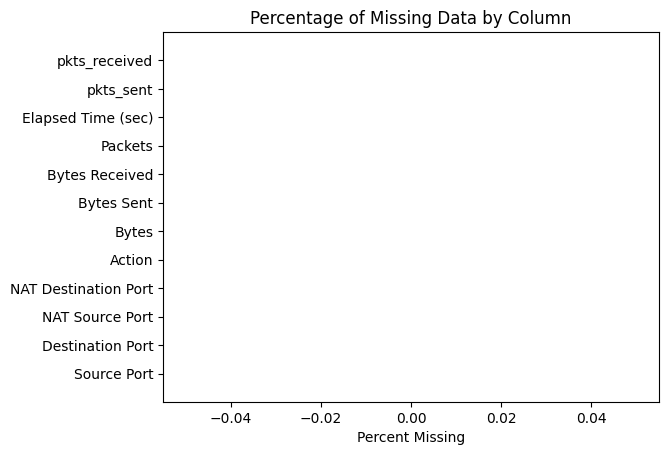

In [48]:
# Create bar chart of missing data percentages
plt.barh(missing_value_df['column_name'], missing_value_df['percent_missing'])

# Add labels and title
plt.xlabel('Percent Missing')
plt.title('Percentage of Missing Data by Column')

# Display the graph
plt.show()

In [49]:
## no missing data. Good

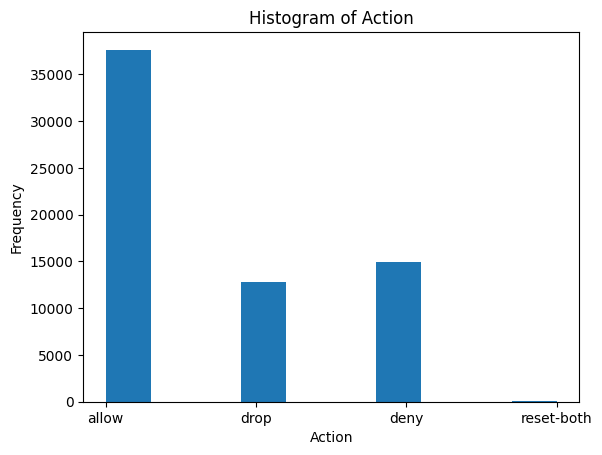

In [50]:
## the response variable is action graph to look at our actions
plt.hist(df['Action'])
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.title('Histogram of Action')
plt.show()

In [51]:
df['Action'].value_counts(normalize=False)


allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

In [52]:
print(df)

       Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
0            57222                53            54587                    53   
1            56258              3389            56258                  3389   
2             6881             50321            43265                 50321   
3            50553              3389            50553                  3389   
4            50002               443            45848                   443   
...            ...               ...              ...                   ...   
65527        63691                80            13237                    80   
65528        50964                80            13485                    80   
65529        54871               445                0                     0   
65530        54870               445                0                     0   
65531        54867               445                0                     0   

      Action    Bytes  Bytes Sent  Bytes Received  

In [53]:
# Select columns to scale
# do not scale source and destination ports... domain knowledge
cols_to_scale = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']

# Scale selected columns
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])

# Print the scaled dataframe
print(df_scaled.head())


   Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
0        57222                53            54587                    53   
1        56258              3389            56258                  3389   
2         6881             50321            43265                 50321   
3        50553              3389            50553                  3389   
4        50002               443            45848                   443   

  Action     Bytes  Bytes Sent  Bytes Received   Packets  Elapsed Time (sec)  \
0  allow -0.017255   -0.005823       -0.030308 -0.019651           -0.118474   
1  allow -0.016438   -0.005430       -0.029056 -0.016339           -0.161455   
2  allow -0.017244   -0.005817       -0.030293 -0.019651            3.746507   
3  allow -0.016695   -0.005472       -0.029575 -0.017118           -0.161455   
4  allow -0.012773   -0.004077       -0.022799 -0.014001           -0.164761   

   pkts_sent  pkts_received  
0  -0.012551      -0.027197  
1  -0.00

In [54]:
# create a list of categorical feature column names
cat_cols = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']

# create a OneHotEncoder object
encoder = OneHotEncoder()

# encode each categorical feature independently
for col in cat_cols:
    # fit and transform the data for the current feature column
    encoded = encoder.fit_transform(df_scaled[col].values.reshape(-1,1))
    # create column names for the encoded features
    enc_col_names = [col + '_' + str(cat) for cat in encoder.categories_[0]]
    # create a dataframe from the encoded features and append it to the original dataframe
    enc_df = pd.DataFrame(encoded.toarray(), columns=enc_col_names)
    df_scaled = pd.concat([df_scaled, enc_df], axis=1)
    

df_scaled

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),...,NAT Destination Port_64932,NAT Destination Port_65054,NAT Destination Port_65100,NAT Destination Port_65128,NAT Destination Port_65253,NAT Destination Port_65264,NAT Destination Port_65387,NAT Destination Port_65427,NAT Destination Port_65534,NAT Destination Port_65535
0,57222,53,54587,53,allow,-0.017255,-0.005823,-0.030308,-0.019651,-0.118474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,56258,3389,56258,3389,allow,-0.016438,-0.005430,-0.029056,-0.016339,-0.161455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6881,50321,43265,50321,allow,-0.017244,-0.005817,-0.030293,-0.019651,3.746507,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50553,3389,50553,3389,allow,-0.016695,-0.005472,-0.029575,-0.017118,-0.161455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50002,443,45848,443,allow,-0.012773,-0.004077,-0.022799,-0.014001,-0.164761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,-0.017231,-0.005798,-0.030293,-0.018871,-0.168067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65528,50964,80,13485,80,allow,0.815823,0.011736,1.842607,0.890740,0.036919,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65529,54871,445,0,0,drop,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65530,54870,445,0,0,drop,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
#We want to change the Action column here to numerical data for algorithms. 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#Using fit.transform function to fit label
#encoder and return encoded labels
label = le.fit_transform(df_scaled['Action'])

#Print unique values
print(label)

#Remove the column "Action" from the original dataframe
#df_scaled.drop('Action', axis = 1, inplace=True)

#Appending the array to the dataframe
df_scaled['Label_Action'] = df_scaled['Action']
df_scaled['Action'] = label

#Print Dataframe 0 = Allow, 1 = Deny, 2 =  Drop , 3 = Reset-Both
df_scaled['Action'].unique()

[0 0 0 ... 2 2 2]


array([0, 2, 1, 3])

In [56]:
df_scaled

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),...,NAT Destination Port_65054,NAT Destination Port_65100,NAT Destination Port_65128,NAT Destination Port_65253,NAT Destination Port_65264,NAT Destination Port_65387,NAT Destination Port_65427,NAT Destination Port_65534,NAT Destination Port_65535,Label_Action
0,57222,53,54587,53,0,-0.017255,-0.005823,-0.030308,-0.019651,-0.118474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,allow
1,56258,3389,56258,3389,0,-0.016438,-0.005430,-0.029056,-0.016339,-0.161455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,allow
2,6881,50321,43265,50321,0,-0.017244,-0.005817,-0.030293,-0.019651,3.746507,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,allow
3,50553,3389,50553,3389,0,-0.016695,-0.005472,-0.029575,-0.017118,-0.161455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,allow
4,50002,443,45848,443,0,-0.012773,-0.004077,-0.022799,-0.014001,-0.164761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,allow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,0,-0.017231,-0.005798,-0.030293,-0.018871,-0.168067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,allow
65528,50964,80,13485,80,0,0.815823,0.011736,1.842607,0.890740,0.036919,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,allow
65529,54871,445,0,0,2,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,drop
65530,54870,445,0,0,2,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,drop


In [57]:
df_OHE_scaled = df_scaled

#Remove the categorical columns from the original dataframe
df_OHE_scaled.drop(['Label_Action','Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port'], axis = 1, inplace=True)

df_OHE_scaled

,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Source Port_0,Source Port_5,...,NAT Destination Port_64932,NAT Destination Port_65054,NAT Destination Port_65100,NAT Destination Port_65128,NAT Destination Port_65253,NAT Destination Port_65264,NAT Destination Port_65387,NAT Destination Port_65427,NAT Destination Port_65534,NAT Destination Port_65535
0,0,-0.017255,-0.005823,-0.030308,-0.019651,-0.118474,-0.012551,-0.027197,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,-0.016438,-0.005430,-0.029056,-0.016339,-0.161455,-0.009755,-0.023598,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,-0.017244,-0.005817,-0.030293,-0.019651,3.746507,-0.012551,-0.027197,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,-0.016695,-0.005472,-0.029575,-0.017118,-0.161455,-0.010376,-0.024498,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,-0.012773,-0.004077,-0.022799,-0.014001,-0.164761,-0.008823,-0.019550,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,0,-0.017231,-0.005798,-0.030293,-0.018871,-0.168067,-0.011619,-0.026747,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65528,0,0.815823,0.011736,1.842607,0.890740,0.036919,0.293149,1.632037,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65529,2,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,-0.012551,-0.027646,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65530,2,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,-0.012551,-0.027646,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Split the data into train and test sets
X = df_scaled.drop('Action', axis=1)
y = df_scaled['Action']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
